In [1]:
import numpy as np 
from numpy import inf
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_absolute_percentage_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

# Все написанные функции лежат здесь
from model_functions import *

# Для автообновления конфига
%load_ext autoreload
%autoreload 2

## 1. Подготовка

### Данные

In [2]:
data_month=pd.read_excel('data_case.xlsx',sheet_name='month')
data_quarter=pd.read_excel('data_case.xlsx',sheet_name='quarter')
descriptions=pd.read_excel('data_case.xlsx',sheet_name='description')

## 2. Генерация признаков

### Генерим признаки

In [16]:
# Темпы роста/прироста
data_growth=gen_growth(data_month,data_month.drop(['period','target'],axis=1).columns)
# Лаги
data_lag_1_all=gen_lag(data_month,data_month.drop(['period','target'],axis=1).columns,1)
data_lag_1_growth=gen_lag(data_growth,data_growth.drop(['period'],axis=1).columns,1)
data_lag_2_all=gen_lag(data_month,data_month.drop(['period','target'],axis=1).columns,2)
data_lag_2_growth=gen_lag(data_growth,data_growth.drop(['period'],axis=1).columns,2)
data_lag_3_all=gen_lag(data_month,data_month.drop(['period','target'],axis=1).columns,3)
data_lag_3_growth=gen_lag(data_growth,data_growth.drop(['period'],axis=1).columns,3)
# Объединяем
features=data_growth.merge(data_lag_1_all,on='period'). \
                          merge(data_lag_1_growth,on='period'). \
                          merge(data_lag_2_all,on='period'). \
                          merge(data_lag_2_growth,on='period'). \
                          merge(data_lag_3_all,on='period'). \
                          merge(data_lag_3_growth,on='period')

features=features.merge(data_month,on='period').drop('target',axis=1)
# Удаляем пропуски
# data_model=data_model.dropna()
print(f'Число наблюдений: {len(features)}')
print(f'Начальный период: {features["period"].min()}')
print(f'Конечный период: {features["period"].max()}')

Число наблюдений: 162
Начальный период: 2009-08-01 00:00:00
Конечный период: 2023-01-01 00:00:00


### Генерим варианты целевой переменной

In [17]:
# Вариант 1. Исходный таргет
data_model_target=features.merge(data_month[['period','target']],on='period')
# Вариант 2. Темпы прироста
target_growth=gen_growth(data_month,['target'])
data_model_delta=features.merge(target_growth[['period','delta_rate_target']],on='period')
data_model_delta.rename({'delta_rate_target': 'target'},inplace=True,axis=1)
# Вариант 3. Первые разности темпов прироста
diff_delta=pd.DataFrame({'period':data_month.period[2:], 
                          'target':target_growth['delta_rate_target'][1:].values-target_growth['delta_rate_target'][:-1].values })
data_model_diff_delta=features.merge(diff_delta[['period','target']],on='period')

## 3. Отбор признаков

Для отбора признаков используется shap (в качестве регрессора взят LGBMRegressor, т.к. он работает с пропусками и inf)

### Считаем shap для каждой задачи

In [18]:
%%time
df_shap_target = calculate_shap_importance(data_model_target,
                                           data_model_target.drop(['period','target'],axis=1).columns.tolist())
df_shap_delta = calculate_shap_importance(data_model_delta,
                                          data_model_delta.drop(['period','target'],axis=1).columns.tolist())
df_shap_diff = calculate_shap_importance(data_model_diff_delta,
                                          data_model_diff_delta.drop(['period','target'],axis=1).columns.tolist())

Wall time: 472 ms


### Отбираем top_n признаков для каждой задачи

In [19]:
top_n=30

features_list_target=df_shap_target.head(top_n)['shap_value'].index.tolist()
features_list_delta=df_shap_delta.head(top_n)['shap_value'].index.tolist()
features_list_diff_delta=df_shap_diff.head(top_n)['shap_value'].index.tolist()

## 4. Baseline (LGBMRegressor)

### 4.1. Целевая переменная - исходный таргет

Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),99.79,-1190.00,12.93
MAPE (%),1.34,14.12,9.54


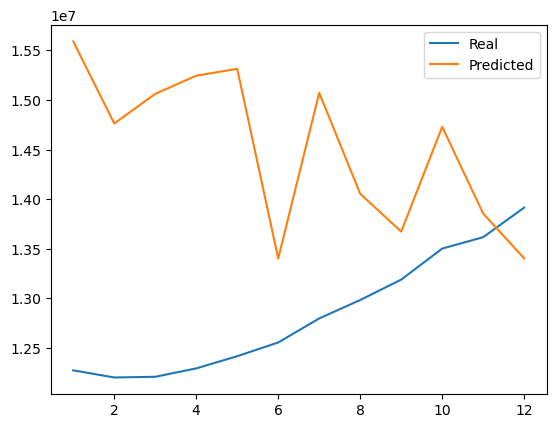

Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),99.81,-78.11,1.78
MAPE (%),1.27,7.97,5.28


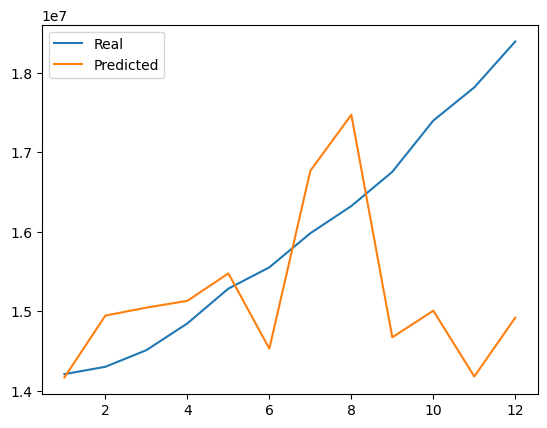

Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),99.83,-179.68,2.80
MAPE (%),1.02,9.45,8.26


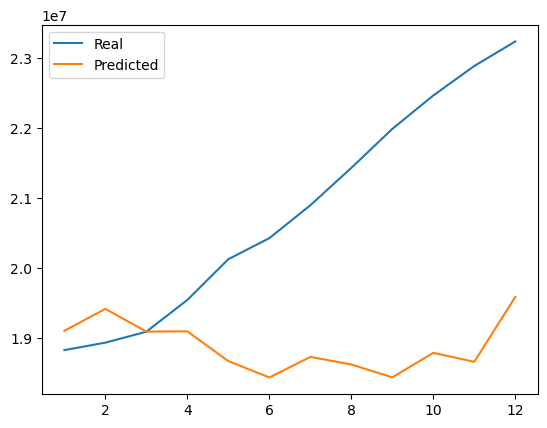

Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),99.84,22.83,0.77
MAPE (%),1.07,3.73,2.49


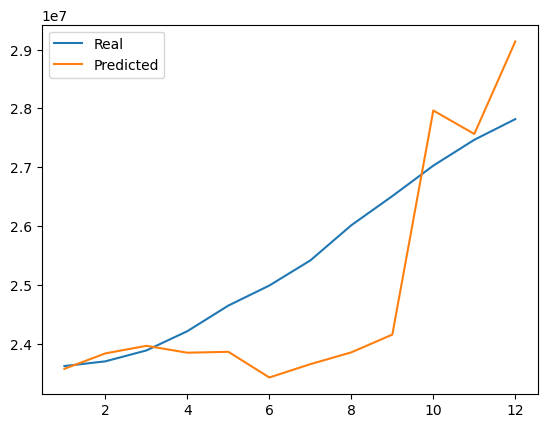

Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),99.84,62.07,0.38
MAPE (%),1.03,2.22,1.16


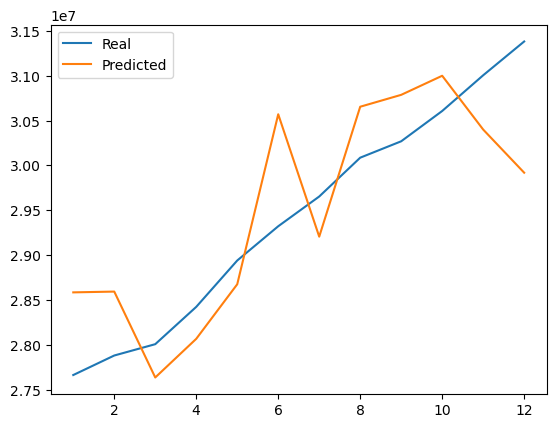

Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),99.84,-912.68,10.14
MAPE (%),1.02,2.65,1.60


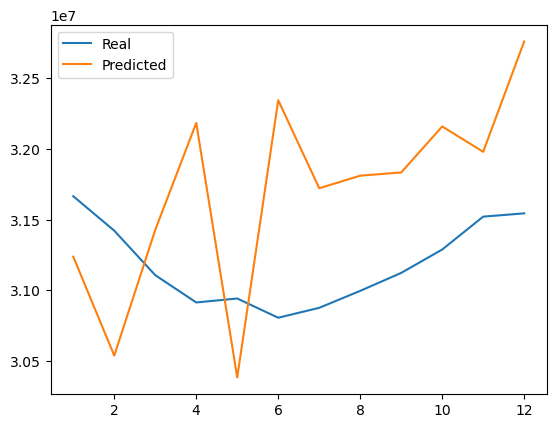

Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),99.85,-456.83,5.58
MAPE (%),0.95,2.01,1.12


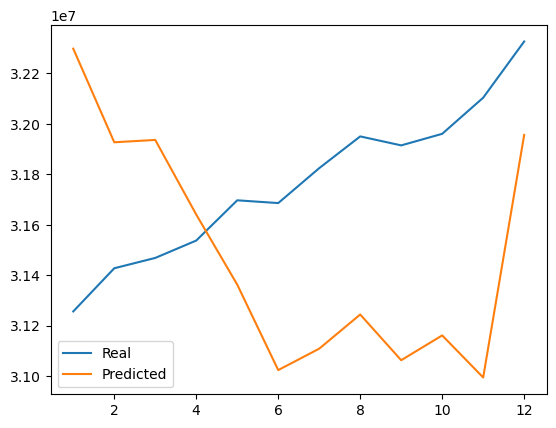

Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),99.85,-235.50,3.36
MAPE (%),1.00,4.09,3.09


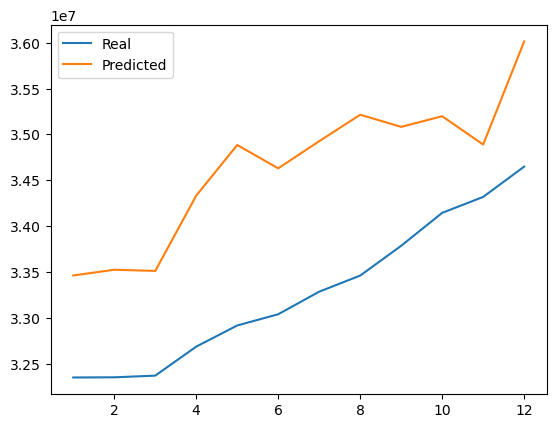

Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),99.84,8.35,0.92
MAPE (%),1.01,3.52,2.49


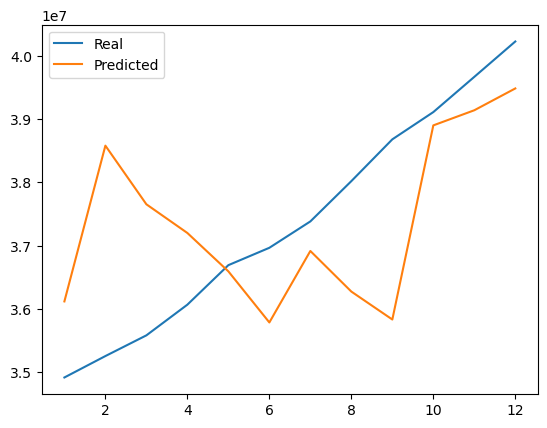

Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),99.84,13.49,0.86
MAPE (%),1.04,2.33,1.24


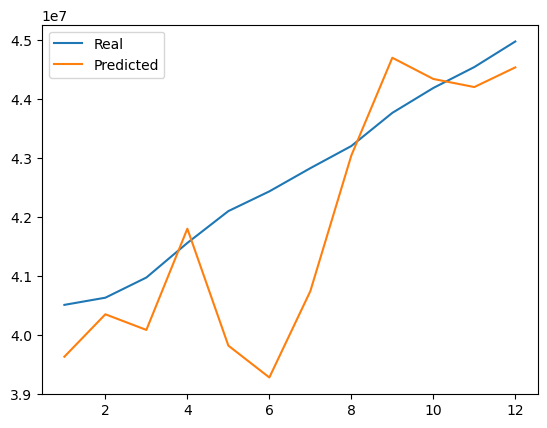

Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),99.83,-316.81,4.17
MAPE (%),1.03,6.55,5.36


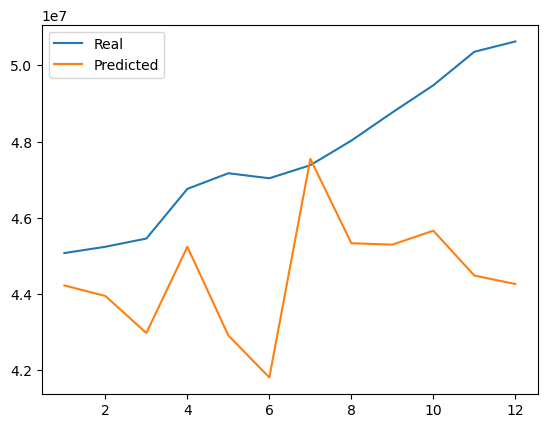

Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),99.74,46.01,0.54
MAPE (%),1.26,3.58,1.84


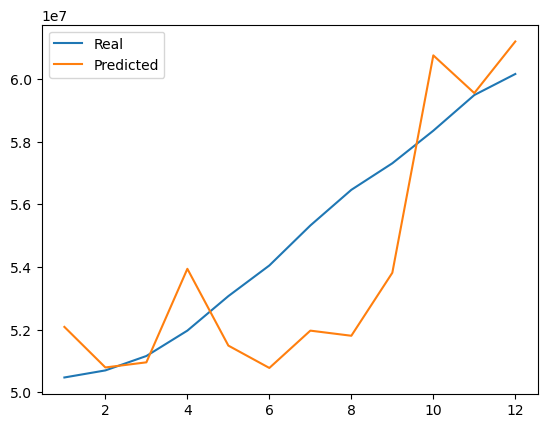

Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),99.08,-504.71,6.09
MAPE (%),1.19,12.16,9.22


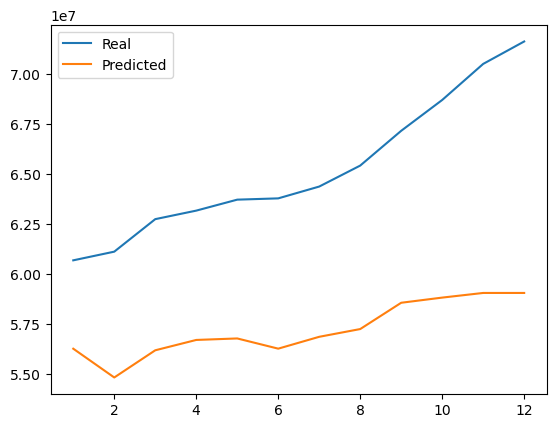

In [20]:
for year in range(2010,2023):
    ## Берём данные для модели
    data_model=data_model_target[['period','target']+features_list_target]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<str(year))|(data_model.period>=str(year+1))]
    data_test=data_model[(data_model.period>=str(year))&(data_model.period<str(year+1))]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LGBMRegressor().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(range(1,13),y_test, label='Real')
    plt.plot(range(1,13),y_test_pred, label='Predicted')
    plt.legend()
    plt.show()

### 4.2. Целевая переменная - темпы прироста

Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),97.74,35.54,0.64
MAPE (%),25.12,237.61,8.46


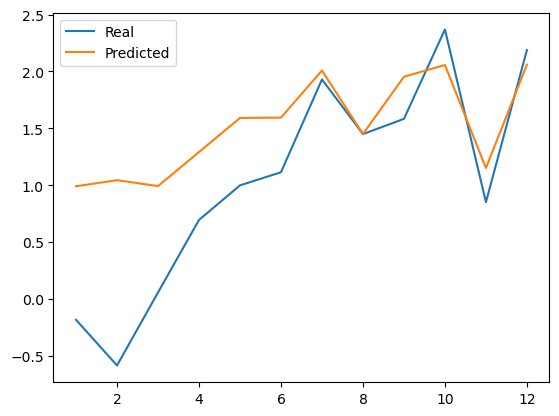

Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),97.52,29.07,0.70
MAPE (%),23.52,29.83,0.27


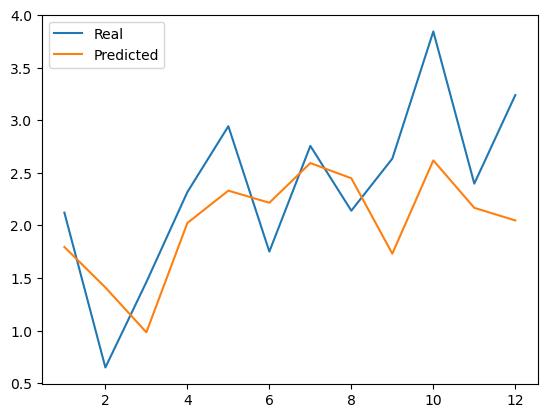

Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),97.52,51.58,0.47
MAPE (%),37.33,24.63,0.34


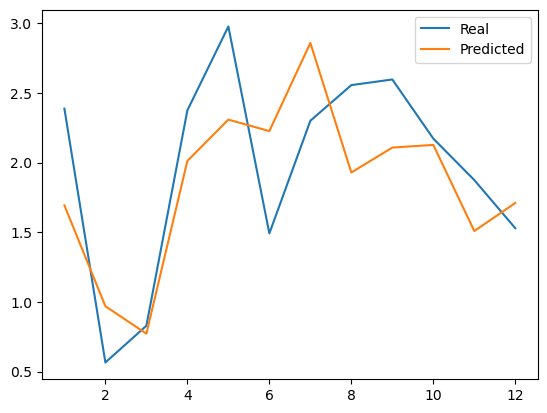

Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),97.81,67.63,0.31
MAPE (%),35.13,21.72,0.38


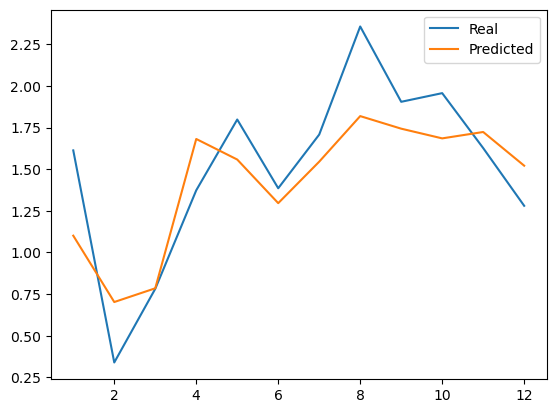

Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),97.78,-55.77,1.57
MAPE (%),39.39,73.07,0.86


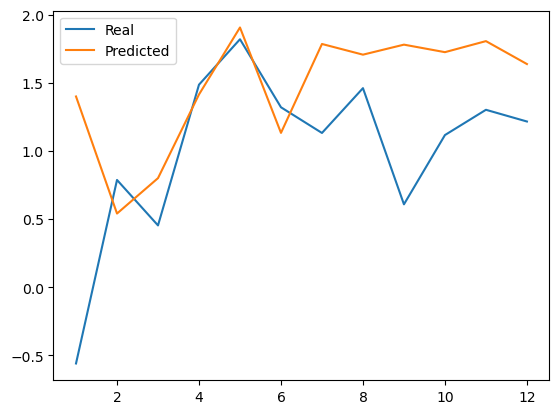

Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),97.60,17.23,0.82
MAPE (%),29.53,129.01,3.37


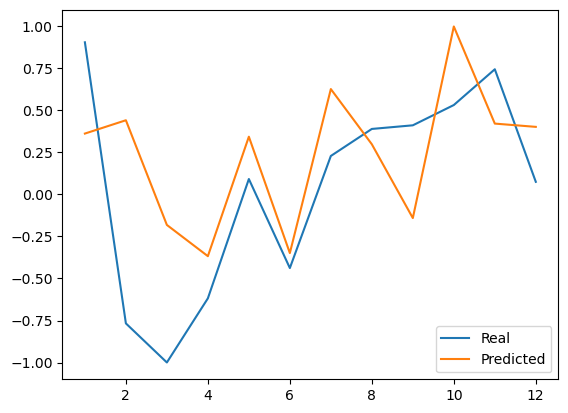

Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),97.57,27.04,0.72
MAPE (%),18.93,160.47,7.48


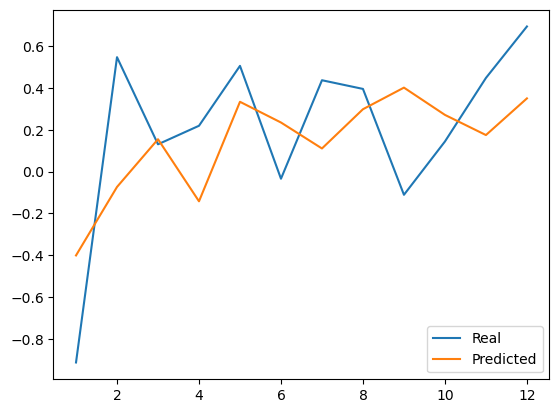

Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),97.74,37.71,0.61
MAPE (%),18.20,921.68,49.64


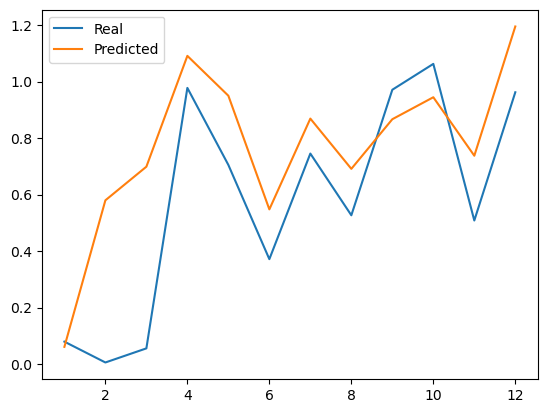

Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),97.92,-124.43,2.27
MAPE (%),24.92,37.94,0.52


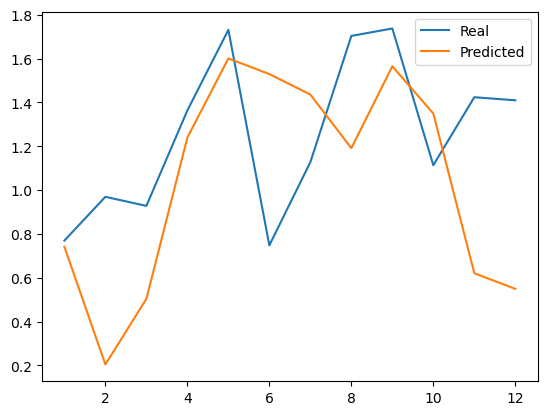

Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),97.86,-41.13,1.42
MAPE (%),31.28,41.22,0.32


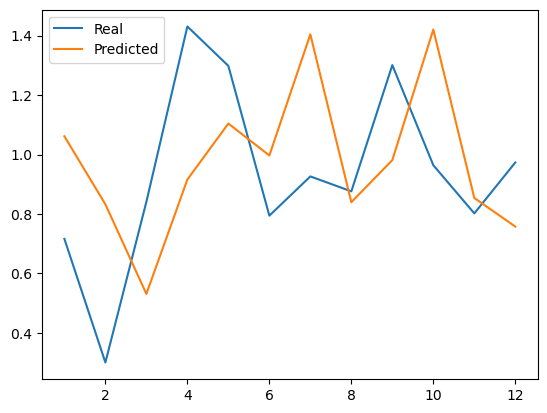

Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),97.78,40.05,0.59
MAPE (%),26.14,59.05,1.26


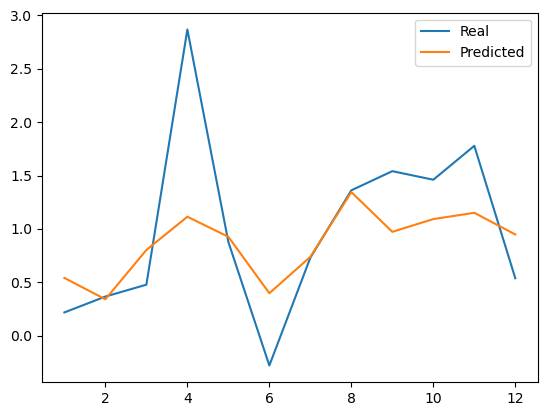

Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),97.95,43.64,0.55
MAPE (%),29.37,54.60,0.86


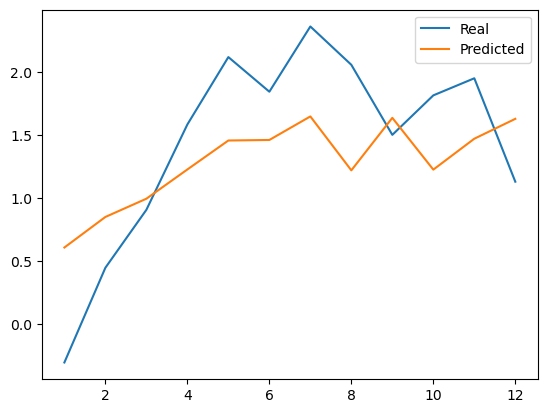

Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),97.77,33.60,0.66
MAPE (%),34.66,116.62,2.36


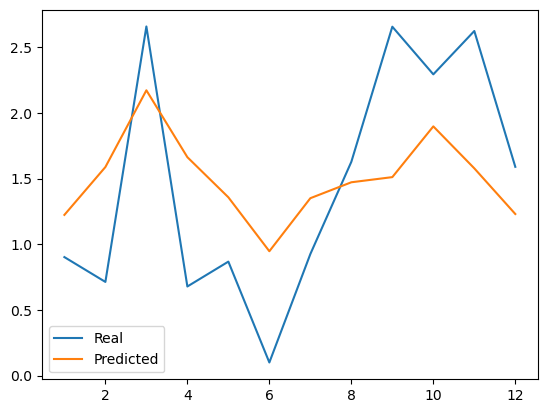

In [21]:
for year in range(2010,2023):
    ## Берём данные для модели
    data_model=data_model_delta[['period','target']+features_list_delta]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<str(year))|(data_model.period>=str(year+1))]
    data_test=data_model[(data_model.period>=str(year))&(data_model.period<str(year+1))]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LGBMRegressor().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(range(1,13),y_test, label='Real')
    plt.plot(range(1,13),y_test_pred, label='Predicted')
    plt.legend()
    plt.show()

### 4.3 Целевая переменная - первые разности темпов прироста

Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),96.16,32.41,0.66
MAPE (%),39.05,75.53,0.93


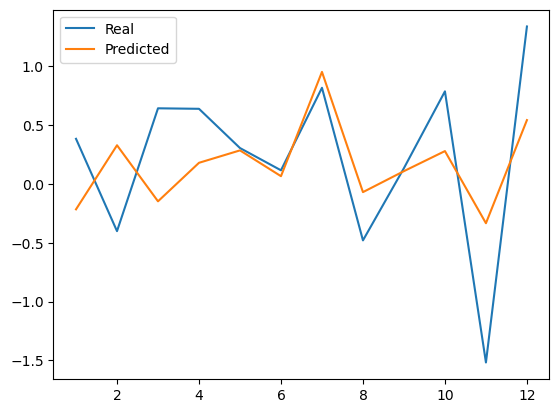

Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),96.39,40.25,0.58
MAPE (%),38.37,108.34,1.82


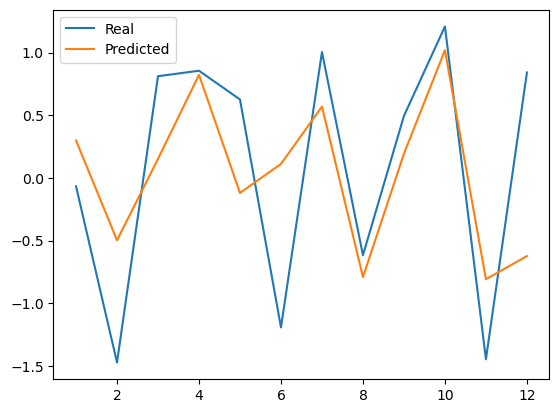

Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),96.35,57.50,0.40
MAPE (%),40.22,115.12,1.86


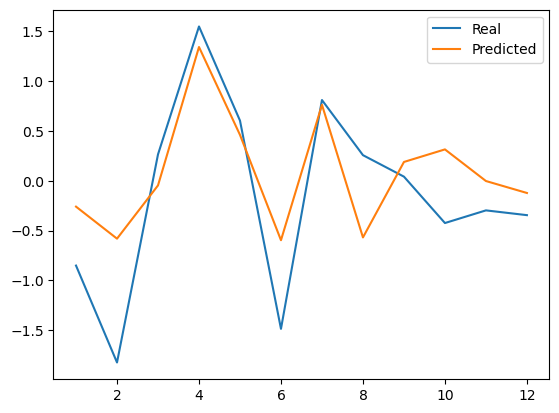

Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),96.18,7.99,0.92
MAPE (%),42.98,115.87,1.70


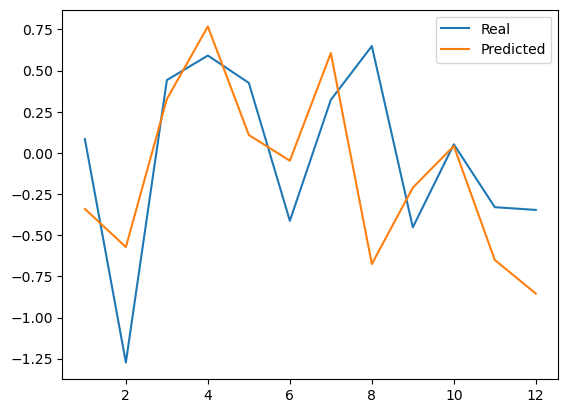

Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),95.94,36.62,0.62
MAPE (%),45.41,81.08,0.79


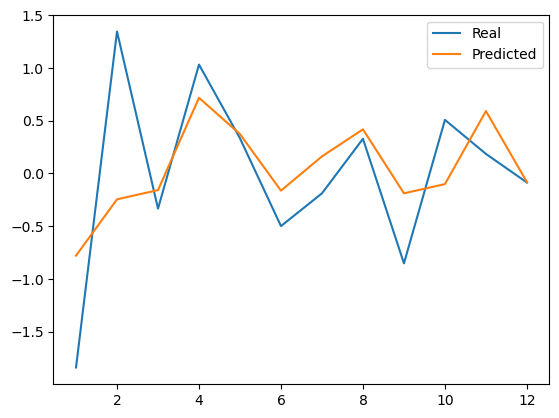

Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),96.51,30.45,0.68
MAPE (%),34.89,245.63,6.04


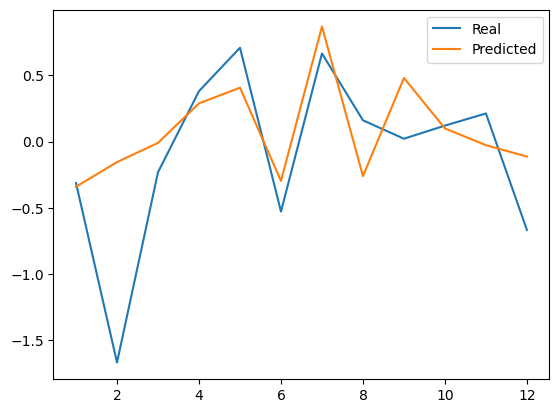

Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),95.87,42.83,0.55
MAPE (%),41.99,126.05,2.00


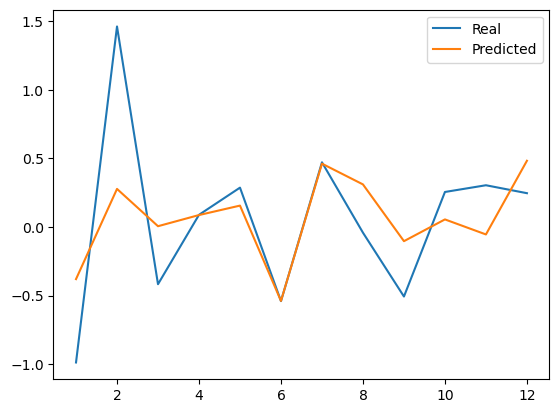

Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),95.82,54.43,0.43
MAPE (%),44.95,83.77,0.86


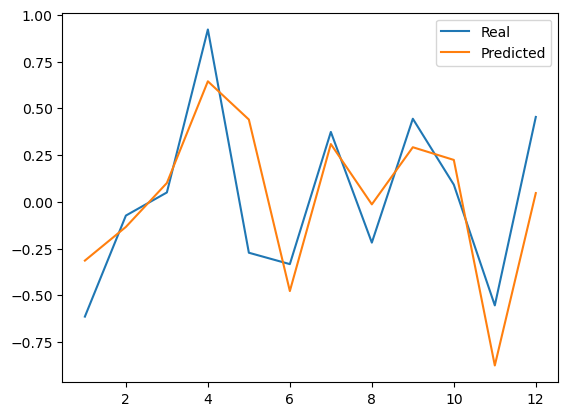

Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),96.92,-30.47,1.31
MAPE (%),29.58,267.89,8.06


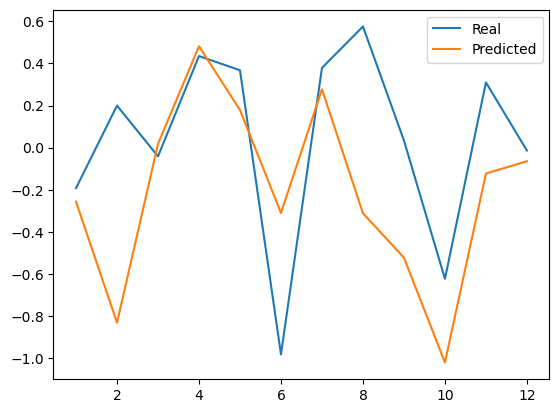

Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),96.10,-42.56,1.44
MAPE (%),47.39,213.42,3.50


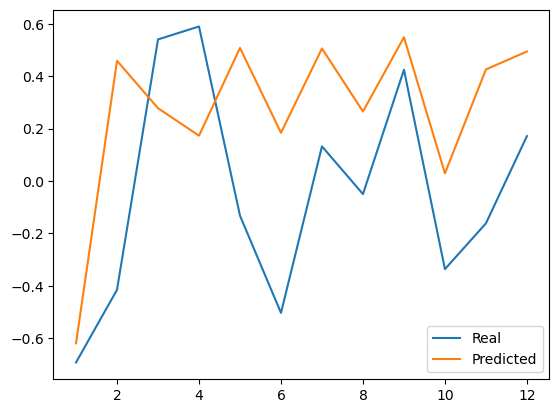

Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),95.69,41.81,0.56
MAPE (%),46.31,137.14,1.96


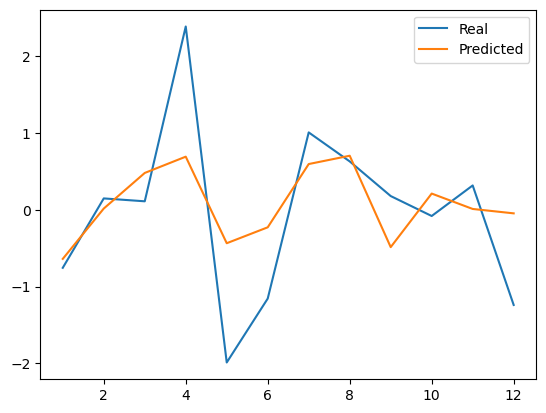

Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),96.71,43.65,0.55
MAPE (%),41.10,78.06,0.90


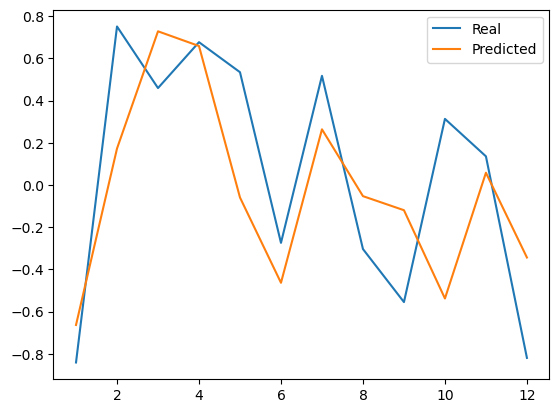

Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),96.08,22.38,0.77
MAPE (%),37.81,121.35,2.21


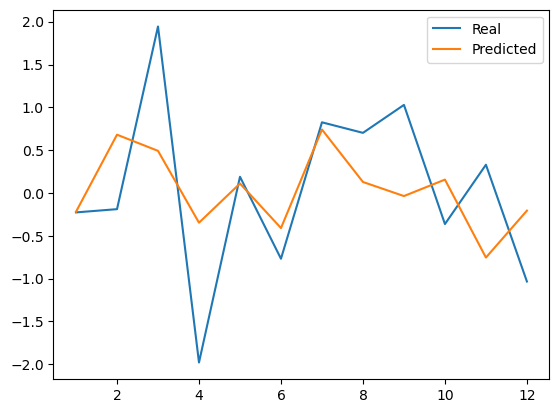

In [23]:
for year in range(2010,2023):
    ## Берём данные для модели
    data_model=data_model_diff_delta[['period','target']+features_list_diff_delta]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<str(year))|(data_model.period>=str(year+1))]
    data_test=data_model[(data_model.period>=str(year))&(data_model.period<str(year+1))]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LGBMRegressor().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(range(1,13),y_test, label='Real')
    plt.plot(range(1,13),y_test_pred, label='Predicted')
    plt.legend()
    plt.show()

## 5. Baseline (LinearRegression)

### Подготовим данные для модели (обработаем пропуски и inf)

In [24]:
# Обрабатываем пропуски
data_model_target_lr=data_model_target.fillna(data_model_target.median())
data_model_delta_lr=data_model_delta.fillna(data_model_delta.median())
data_model_diff_delta_lr=data_model_diff_delta.fillna(data_model_diff_delta.median())
# Обрабатываем inf
data_model_target_lr.replace([np.inf, -np.inf], 0, inplace=True)
data_model_delta_lr.replace([np.inf, -np.inf], 0, inplace=True)
data_model_diff_delta_lr.replace([np.inf, -np.inf], 0, inplace=True)

### 51. Целевая переменная - исходный таргет

Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),97.06,-8036.10,83.80
MAPE (%),6.74,40.16,4.96


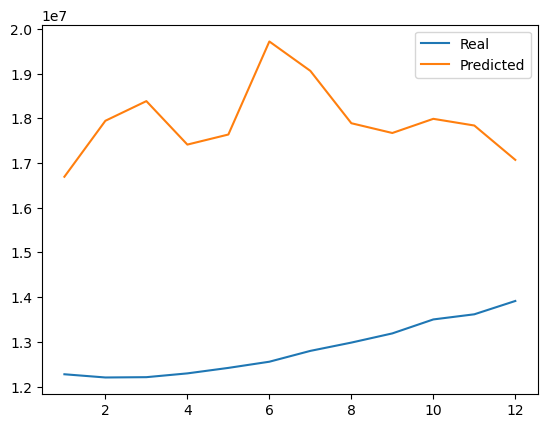

Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),96.91,-504.23,6.20
MAPE (%),7.10,19.64,1.77


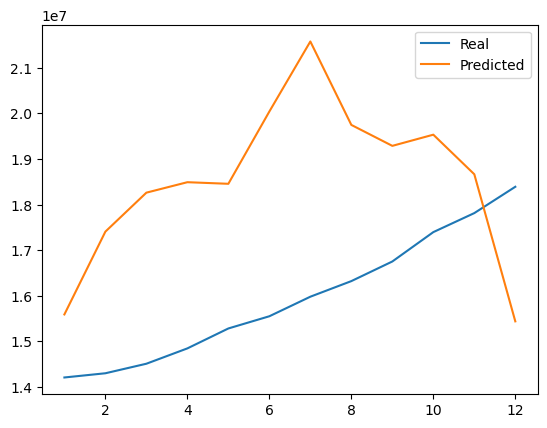

Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),96.89,-42.65,1.44
MAPE (%),7.59,7.39,0.03


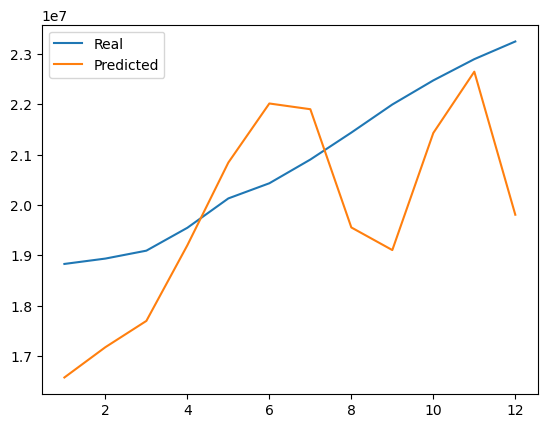

Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),97.25,-578.72,6.95
MAPE (%),7.37,13.43,0.82


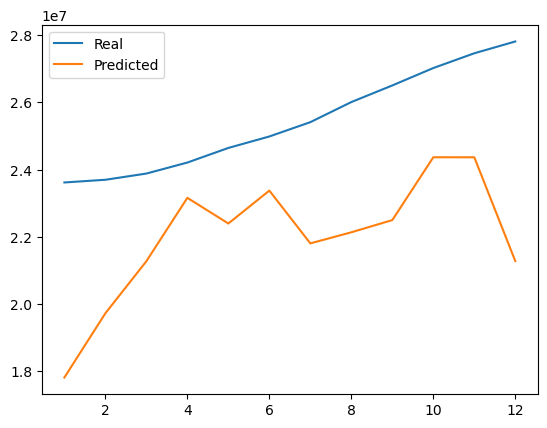

Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),97.19,-628.65,7.47
MAPE (%),7.79,10.38,0.33


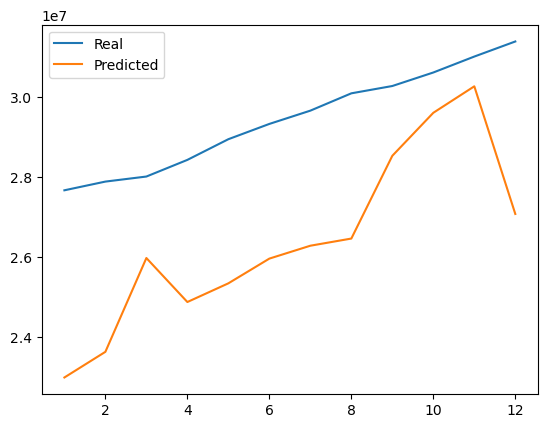

Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),97.05,-2728.99,29.12
MAPE (%),7.93,3.97,0.50


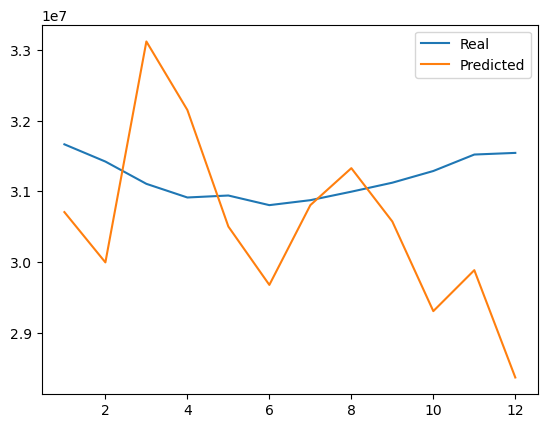

Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),97.10,-5949.63,62.27
MAPE (%),7.78,5.77,0.26


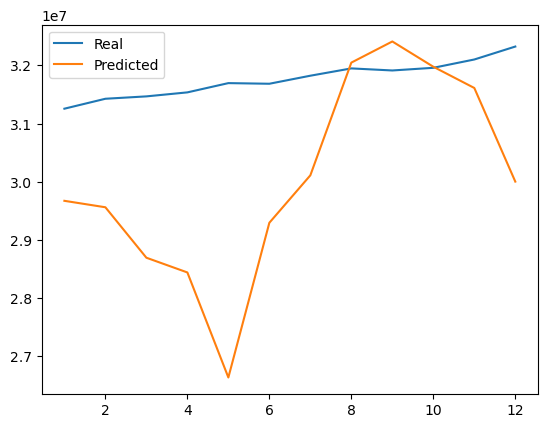

Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),97.07,-380.01,4.91
MAPE (%),7.94,4.43,0.44


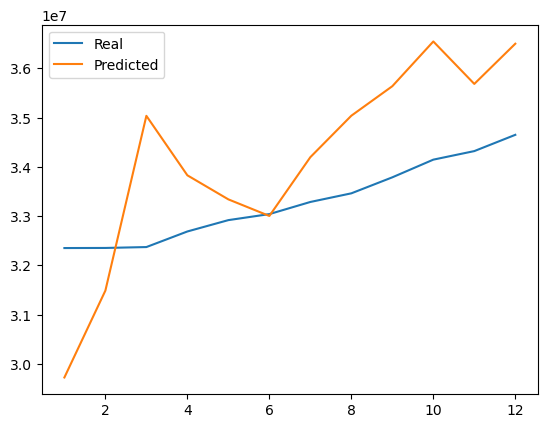

Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),97.32,-388.09,4.99
MAPE (%),7.64,8.23,0.08


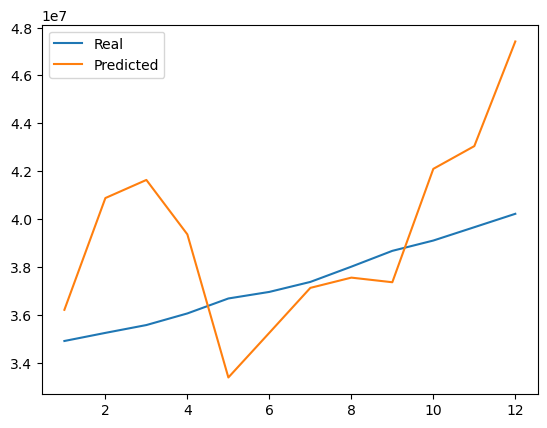

Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),97.12,-386.47,4.98
MAPE (%),7.82,6.35,0.19


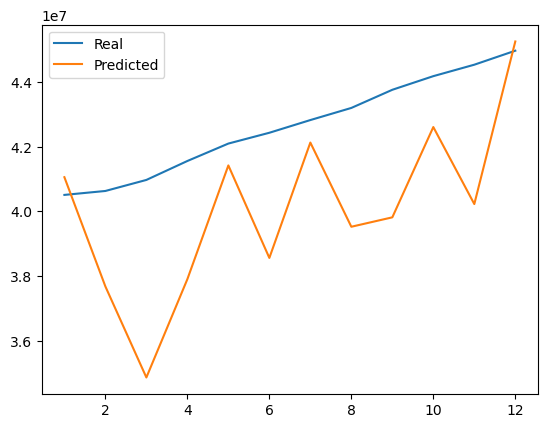

Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),97.64,-2420.11,25.79
MAPE (%),7.12,17.30,1.43


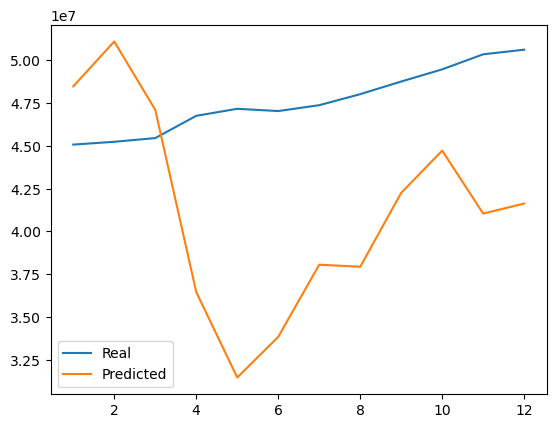

Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),97.77,-1086.61,12.11
MAPE (%),6.91,18.04,1.61


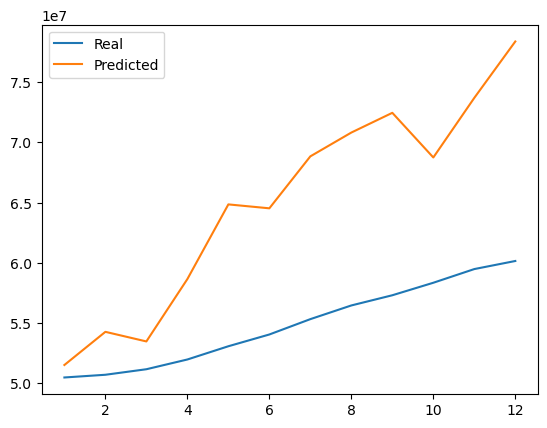

Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),99.42,-3.470656e+16,3.490903e+14
MAPE (%),3.31,3.546209e+07,1.071362e+07


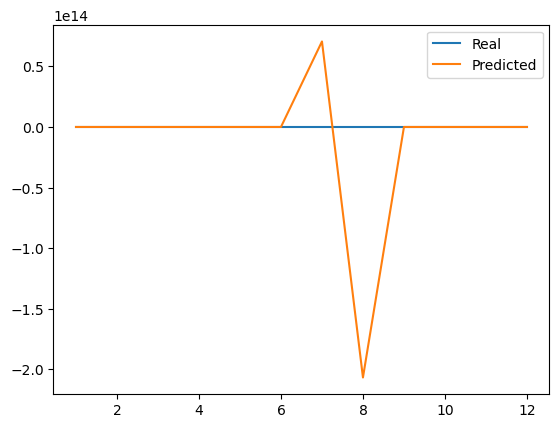

In [25]:
for year in range(2010,2023):
    ## Берём данные для модели
    data_model=data_model_target_lr[['period','target']+features_list_target]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<str(year))|(data_model.period>=str(year+1))]
    data_test=data_model[(data_model.period>=str(year))&(data_model.period<str(year+1))]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LinearRegression().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(range(1,13),y_test, label='Real')
    plt.plot(range(1,13),y_test_pred, label='Predicted')
    plt.legend()
    plt.show()

### 4.2. Целевая переменная - темпы прироста

Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),73.98,57.86,0.22
MAPE (%),54.99,189.82,2.45


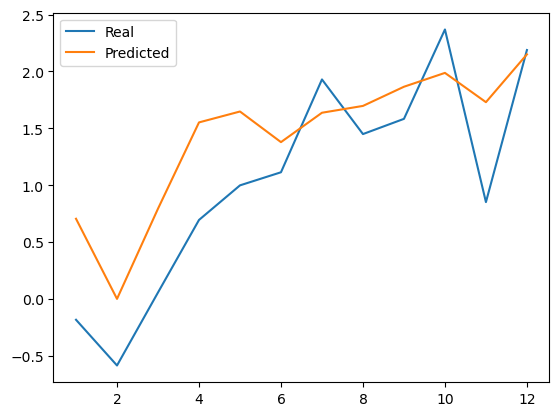

Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),71.16,18.54,0.74
MAPE (%),65.93,23.99,0.64


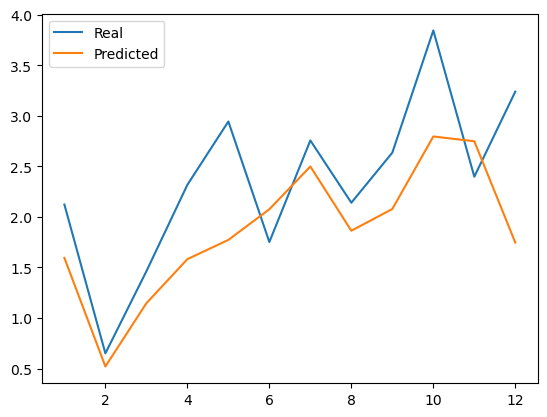

Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),74.69,-8.65,1.12
MAPE (%),65.27,30.39,0.53


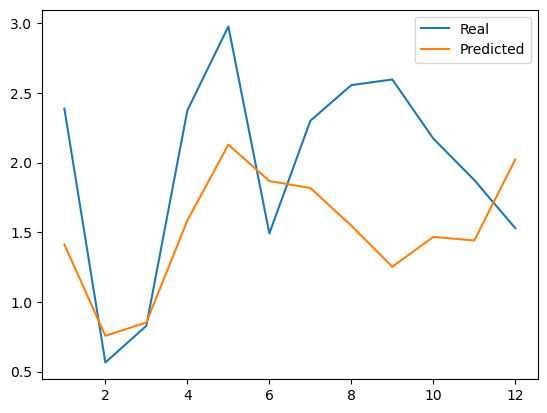

Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),74.43,-3961.65,54.23
MAPE (%),76.04,90.13,0.19


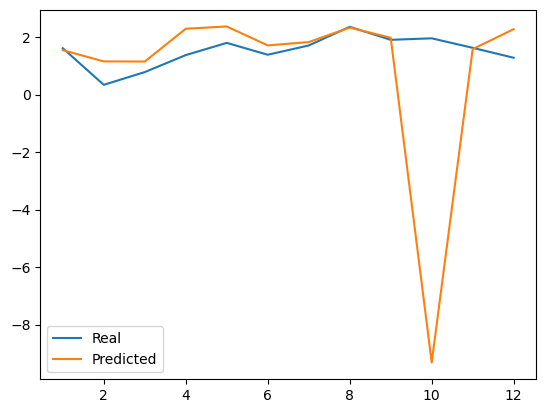

Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),77.23,-86.75,2.12
MAPE (%),75.31,82.25,0.09


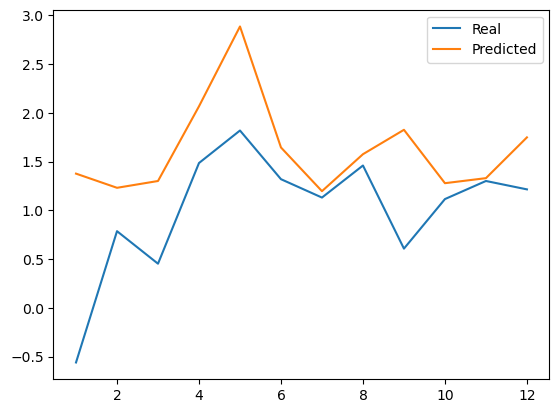

Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),71.06,20.10,0.72
MAPE (%),60.92,94.25,0.55


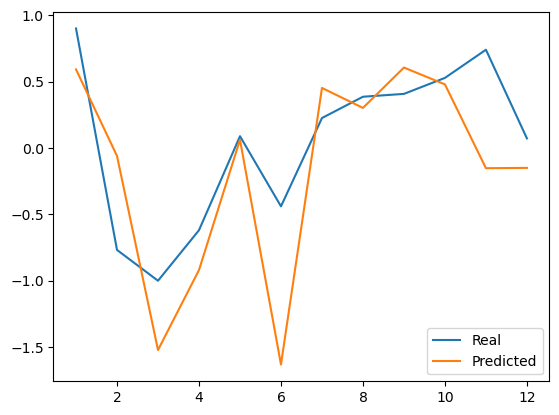

Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),72.89,-42.25,1.58
MAPE (%),75.15,122.53,0.63


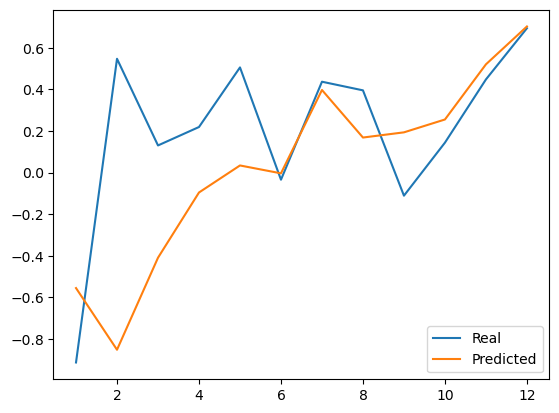

Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),73.25,49.13,0.33
MAPE (%),61.64,166.83,1.71


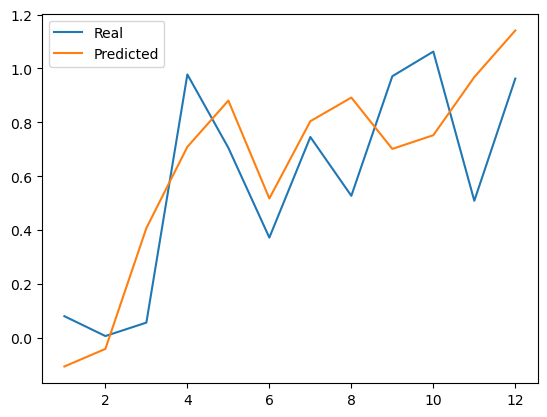

Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),75.17,-84.69,2.13
MAPE (%),77.78,36.61,0.53


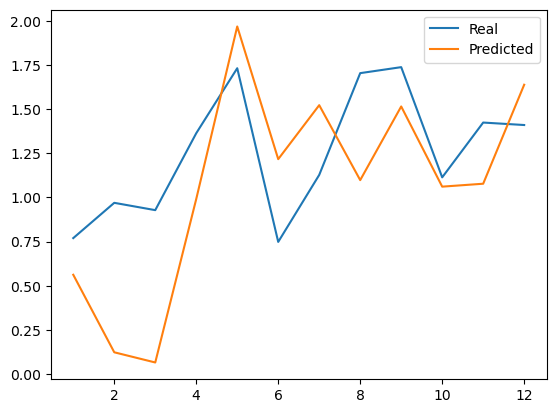

Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),74.34,-60.27,1.81
MAPE (%),73.02,36.74,0.50


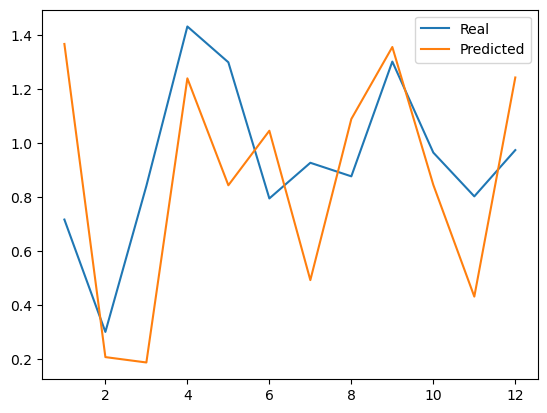

Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),73.82,63.55,0.14
MAPE (%),75.24,57.87,0.23


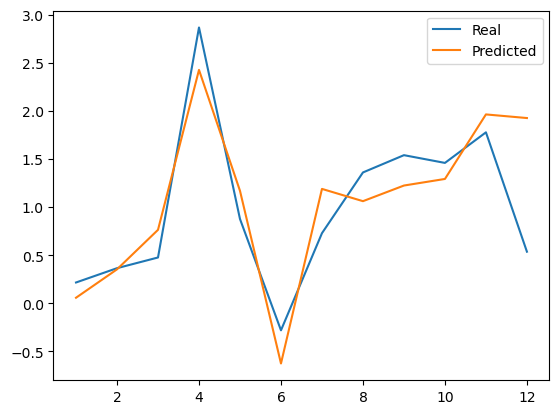

Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),75.10,23.53,0.69
MAPE (%),62.05,62.12,0.00


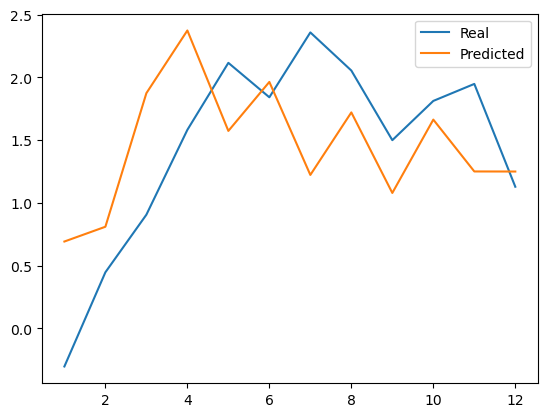

Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),75.99,-137.89,2.81
MAPE (%),66.72,222.12,2.33


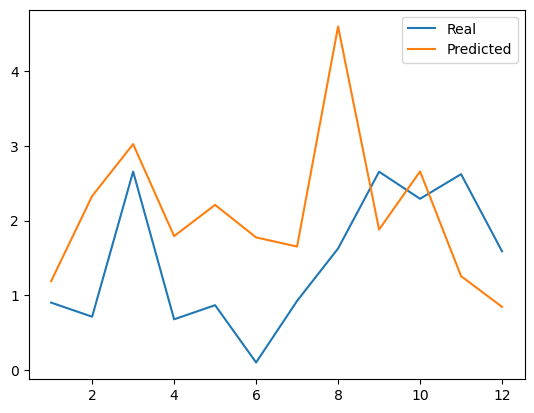

In [118]:
for year in range(2010,2023):
    ## Берём данные для модели
    data_model=data_model_delta_lr[['period','target']+features_list_delta]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<str(year))|(data_model.period>=str(year+1))]
    data_test=data_model[(data_model.period>=str(year))&(data_model.period<str(year+1))]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LinearRegression().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(range(1,13),y_test, label='Real')
    plt.plot(range(1,13),y_test_pred, label='Predicted')
    plt.legend()
    plt.show()

### 4.3 Целевая переменная - первые разности темпов прироста

Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),53.16,-4.70,1.09
MAPE (%),118.78,115.58,0.03


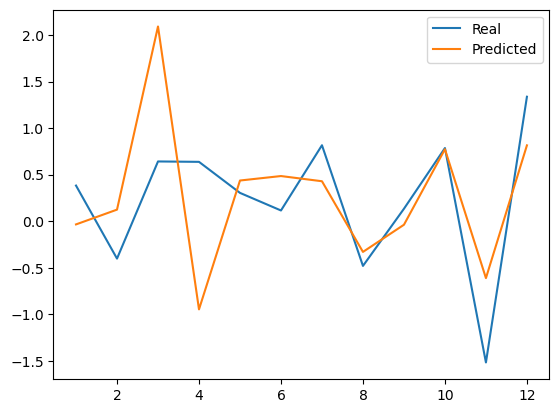

Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),52.83,15.01,0.72
MAPE (%),114.24,107.97,0.05


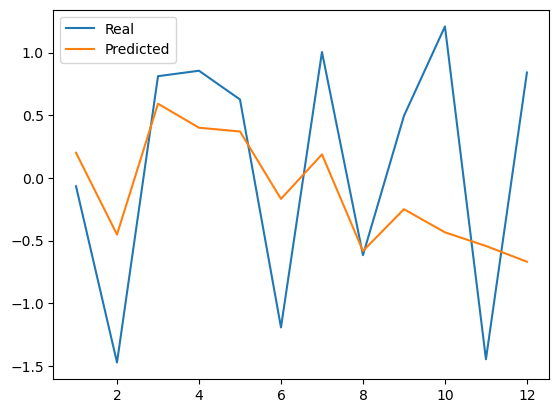

Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),55.34,8.08,0.85
MAPE (%),115.34,133.79,0.16


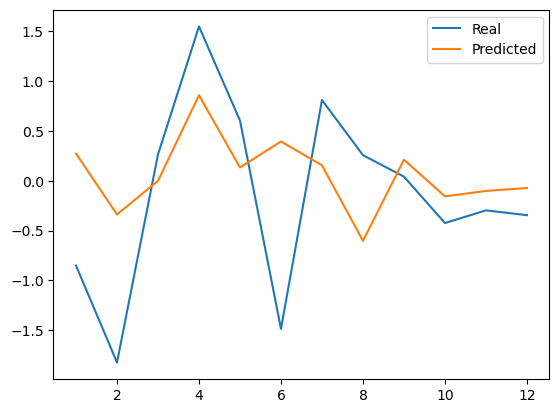

Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),51.91,-807.24,16.55
MAPE (%),117.37,976.33,7.32


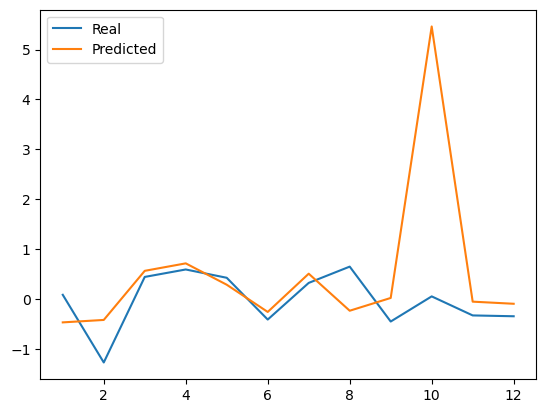

Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),49.69,-4090.40,83.32
MAPE (%),121.46,149.61,0.23


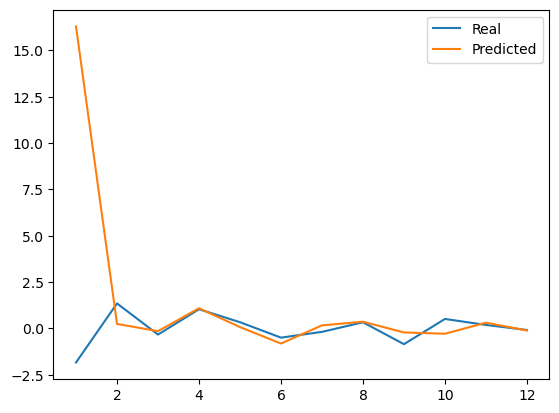

Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),52.46,-104.52,2.99
MAPE (%),113.16,312.58,1.76


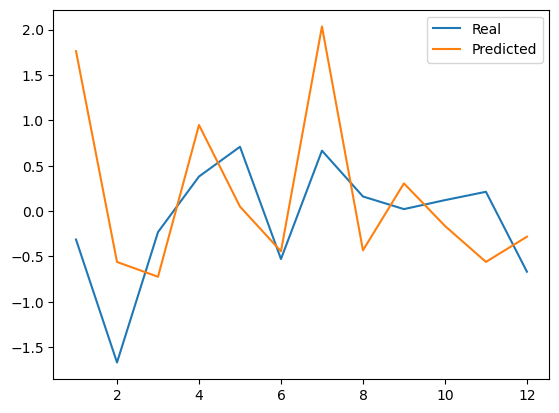

Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),52.90,-1.22,1.02
MAPE (%),115.47,122.36,0.06


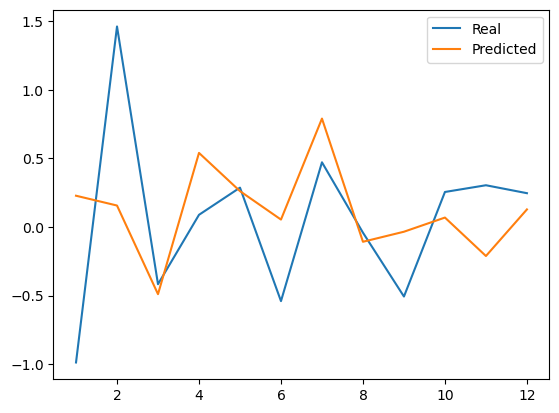

Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),51.85,23.87,0.54
MAPE (%),118.23,146.59,0.24


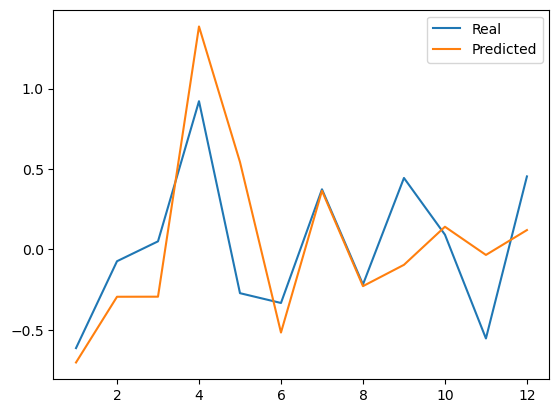

Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),51.93,25.49,0.51
MAPE (%),113.02,197.49,0.75


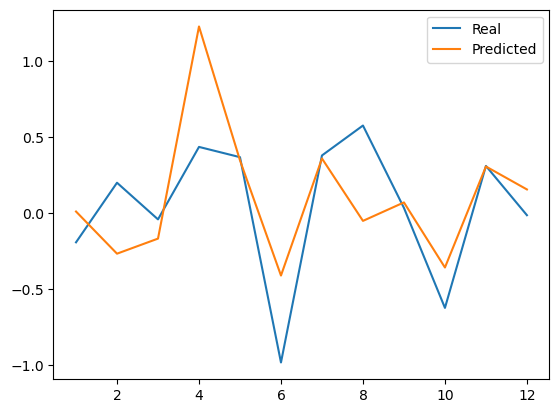

Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),51.72,17.00,0.67
MAPE (%),118.97,127.37,0.07


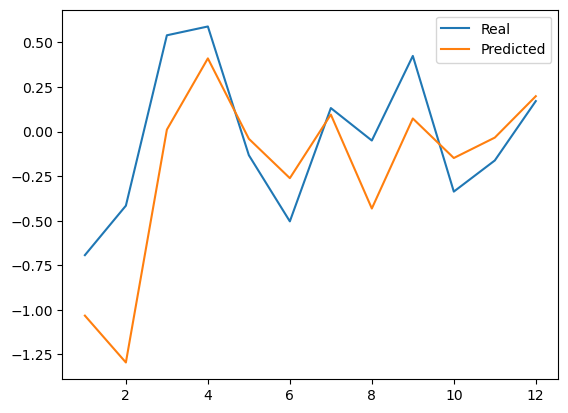

Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),50.03,45.33,0.09
MAPE (%),105.78,195.75,0.85


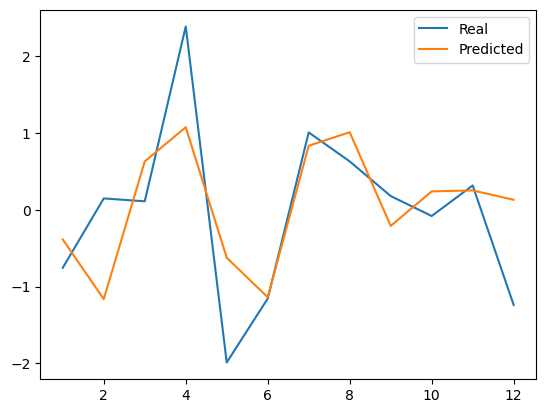

Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),53.78,-22.88,1.43
MAPE (%),124.60,96.56,0.23


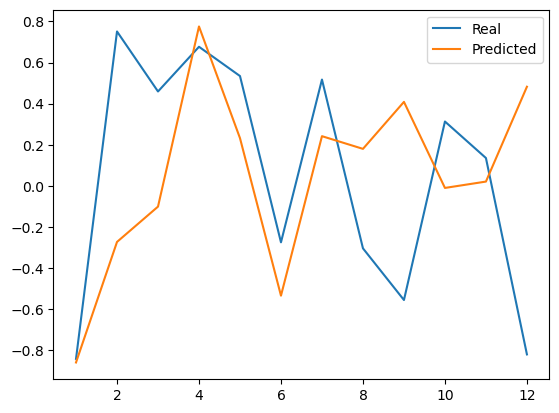

Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),51.87,-111.24,3.14
MAPE (%),118.18,227.32,0.92


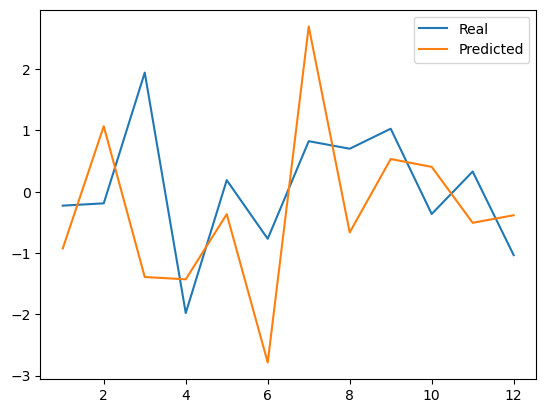

In [26]:
for year in range(2010,2023):
    ## Берём данные для модели
    data_model=data_model_diff_delta_lr[['period','target']+features_list_diff_delta]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<str(year))|(data_model.period>=str(year+1))]
    data_test=data_model[(data_model.period>=str(year))&(data_model.period<str(year+1))]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LinearRegression().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(range(1,13),y_test, label='Real')
    plt.plot(range(1,13),y_test_pred, label='Predicted')
    plt.legend()
    plt.show()